## Табличное Q-обучение


Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686">


<!-- Раскроем скобки:
$$Q(s,a)\leftarrow (1 - \alpha) \times Q(s,a)+\alpha \times \big (r(s)+\gamma\max_{a'}Q(a',s')\big ).$$ -->

Для обучения будем использовать среду Taxi-v3. Подробнее про данное окружение можно посмотреть в документации: https://gymnasium.farama.org/environments/toy_text/taxi/.

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

/Users/cactus_tim/cursor/RL/.conda/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


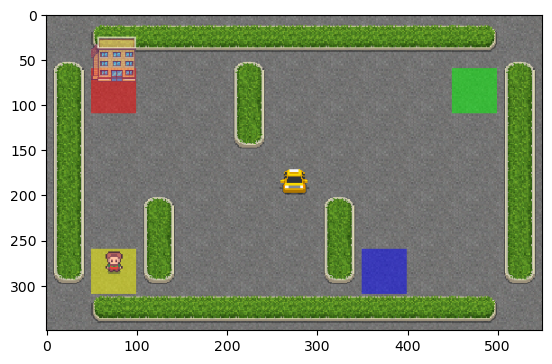

In [3]:
env = gym.make("Taxi-v3", render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [4]:
def show_progress(rewards_batch, log):
    """Функция отображения прогресса обучения."""
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(log, label='Mean rewards')
    plt.legend(loc=4)
    plt.show()

### Задание 1

Создайте таблицу из нулей, используя информацию из окружения о количестве состояний и действий (1 балл)

In [5]:
def initialize_q_table(n_observation_space, n_action_space):
    # Q = [state][action]
    ####### Здесь ваш код ########
    Q = np.zeros((n_observation_space, n_action_space))
    ##############################
    return Q

In [6]:
# Добавить проверку таблицы - размеры, тип.
n_states, n_actions = 3, 5
Q = initialize_q_table(n_states, n_actions)
assert isinstance(Q, np.ndarray) and len(Q.shape) == 2, 'результат должен быть 2D нумпаевским вектором'
assert Q.shape[0] == n_states and Q.shape[1] == n_actions, 'проверь размерности: [N состояний][M действий]'
assert not Q.any(), 'инициализация должна быть нулями'

### Задание 2

Напишите код для epsilon-жадного выбора действия (1 балл):

In [ ]:
def select_action_eps_greedy(Q, state, epsilon):
    # выбираем действие, используя eps-greedy исследование среды:
    # 1) с вероятностью epsilon выбираем случайное действие,
    # 2) иначе выбираем действие жадно
    # action =
    ####### Здесь ваш код ########
    if np.random.random() < epsilon:
        action = np.random.randint(0, Q.shape[1])
    else:
        action = np.argmax(Q[state])
    ##############################
    return action

Напишите код для формулы Q-обновления (1 балл):

In [8]:
def update_Q(Q, s, a, r, next_s, alpha, gamma):
    # alpha: learning rate, gamma: discount factor
    # вычисли V(next_s) - estimate of optimal future value
    # V_ns =
    ####### Здесь ваш код ########
    V_ns = np.max(Q[next_s])
    ##############################

    # посчитай TD ошибку
    # td_error =
    ####### Здесь ваш код ########
    td_error = r + gamma * V_ns - Q[s, a]
    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации Q-обучения (2 балла):

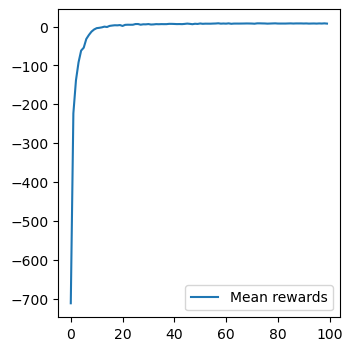

Episode: 10000, Reward: 5, Eps: 0.001246427204280841


In [9]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
n_episodes = 10000

for i_episode in range(1, n_episodes + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        # select action eps-greedy
        # a = ...
        ####### Здесь ваш код ########
        a = select_action_eps_greedy(Q, s, epsilon)
        ##############################

        # выполняем действие в среде
        next_s, r, terminated, truncated, _ = env.step(a)

        # Update Q-function
        ####### Здесь ваш код ########
        update_Q(Q, s, a, r, next_s, alpha, gamma)
        ##############################

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if i_episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(
            f"Episode: {i_episode}, Reward: {episode_reward}"
            f", Eps: {epsilon}"
        )
        epsilon *= epsilon_decay

assert log[-1] >= -10

### Интерпретация результатов (1 балл):
Если все сделано правильно, то график должен выйти на плато около 0. Значение вознаграждение будет в диапазоне [-5, 10], за счет случайного выбора начальной позиции такси и пассажира. Попробуйте изменить гиперпараметры и сравните результаты.

#### Интерпретация результатов Q-learning:

График среднего вознаграждения должен демонстрировать следующие характеристики:

1. **Начальный этап обучения**: На первых эпизодах вознаграждения будут низкими (отрицательными), так как агент еще не знает оптимальной стратегии и совершает случайные действия.

2. **Этап обучения**: По мере обучения агент накапливает знания в Q-таблице и начинает выбирать более оптимальные действия. График должен показывать постепенный рост среднего вознаграждения.

3. **Плато**: После достаточного количества эпизодов график должен выйти на плато около значения 0 или немного выше. Это означает, что агент научился эффективной стратегии.

4. **Диапазон вознаграждений**: Финальные вознаграждения находятся в диапазоне [-5, 10], что связано с:
   - Штрафами за неоптимальные действия (-1 за шаг) и наградами за успешную доставку (+20)

5. **Влияние гиперпараметров**:
   - **alpha (learning rate)**: Более высокие значения ускоряют обучение, но могут привести к нестабильности. Низкие значения делают обучение медленнее, но стабильнее.
   - **gamma (discount factor)**: Определяет важность будущих вознаграждений. Более высокие значения помогают учитывать долгосрочные последствия действий.
   - **epsilon**: Балансирует между исследованием (exploration) и использованием (exploitation). Высокие значения в начале помогают исследовать среду, затем постепенное уменьшение позволяет использовать найденную стратегию.

Успешное обучение характеризуется стабилизацией среднего вознаграждения на уровне близком к 0, что указывает на то, что агент научился эффективно решать задачу Taxi-v3.


## SARSA

Теперь ради интереса попробуем то же самое, но используя метод SARSA.

Для начала, добавим функцию обновления Q-функции (1 балл):

In [11]:
def update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon):
    # выбери следующее действие eps-greedy
    # next_a =
    ####### Здесь ваш код ########
    next_a = select_action_eps_greedy(Q, next_s, epsilon)
    ##############################

    # посчитай TD ошибку
    # td_error =
    ####### Здесь ваш код ########
    td_error = r + gamma * Q[next_s, next_a] - Q[s, a]
    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации SARSA-обучения (2 балла):

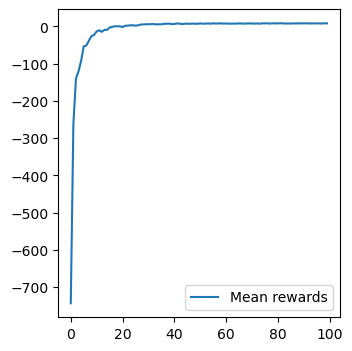

Episode: 10000, Reward: 7, Eps: 0.001246427204280841


In [12]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        # select action eps-greedy
        # a = ...
        ####### Здесь ваш код ########
        a = select_action_eps_greedy(Q, s, epsilon)
        ##############################

        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)

        # Update Q-function with SARSA
        ####### Здесь ваш код ########
        update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon)
        ##############################

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:

        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

assert log[-1] >= -10

Сравнивая SARSA и Q-learning, что можно сказать об их кривых обучения? (быстрее-медленнее, обучение стабильнее или нет и тп) (1 балл)

#### Сравнение SARSA и Q-learning:

**1. Скорость обучения:**
- **Q-learning** обычно обучается быстрее, так как использует максимум Q-значений следующего состояния (оптимистичная оценка)
- **SARSA** обучается медленнее, так как использует фактическое следующее действие, выбранное epsilon-жадной стратегией (консервативная оценка)

**2. Стабильность обучения:**
- **Q-learning** менее стабилен, особенно в стохастических средах или при использовании epsilon-жадной стратегии, так как может переоценивать оптимальные значения
- **SARSA** более стабилен и консервативен, так как учитывает реальную политику, включая исследовательские действия

**3. Исследование vs использование:**
- **Q-learning** (off-policy): Изучает оптимальную политику независимо от текущей политики выбора действий. Может быть более агрессивным в обучении
- **SARSA** (on-policy): Изучает политику, учитывая epsilon-жадный выбор действий. Более безопасен, так как учитывает возможные ошибки исследования

**4. Поведение в средах:**
- **Q-learning** лучше подходит для детерминированных сред и когда нужна агрессивная оптимизация
- **SARSA** лучше подходит для стохастических сред, где важно учитывать риски и быть более консервативным (например, избегать опасных областей)

**5. Кривые обучения:**
- **Q-learning**: График может быть более волатильным (колебания выше), но быстрее достигает более высоких значений вознаграждения
- **SARSA**: График более плавный и стабильный, но может достигать несколько более низких значений вознаграждения из-за консервативности

**Вывод:** В среде Taxi-v3 оба алгоритма должны показывать похожие результаты, но Q-learning может обучаться быстрее, а SARSA быть более стабильным. Выбор зависит от характеристик среды и требований к балансу между скоростью и стабильностью обучения.
